In [29]:
# import necessary libraries

#https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/introduction_to_tensorflow/solutions/preprocessing_layers.ipynb
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/custom/custom-tabular-bq-managed-dataset.ipynb
#https://keras.io/guides/preprocessing_layers/
#https://www.tensorflow.org/guide/keras/preprocessing_layers

import numpy as np
import pandas as pd
from datetime import date, timedelta, datetime # Date Functions
import time
import math


import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,DenseFeatures
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.python.keras.utils import data_utils


from google.cloud import bigquery

print(tf.__version__)

2.11.1


In [30]:
cateCols=['sla','product_type','brand','service_type','incident_type']

numbericCols=['open_to_close_hour','response_to_resolved_hour']

unusedCols=['severity_id','severity_name','label_binary_severity']


labelCol='label_multi_severity'

model_dir='model' # demo


main_metric='accuracy'
main_objective=f'val_{main_metric}'

nEarlyPatience=10

# Load data from BigQuery
projectId='pongthorn'
dataset_id='DemoSMartDW'
 

# Load Data

In [31]:
def load_ml_data(data_path):
 df=pd.read_csv(data_path)
 df =df.drop(columns=unusedCols)
 return df

def load_data_bq(sql:str):
 client_bq = bigquery.Client()
 query_result=client_bq.query(sql)
 df=query_result.to_dataframe()
 df =df.drop(columns=unusedCols)
 return df

In [32]:
train_name='train_incident'
validation_name='validation_incident'
test_name='test_incident'

In [33]:


train_table_id=f"{projectId}.{dataset_id}.{train_name}"
val_tabel_id=f"{projectId}.{dataset_id}.{validation_name}"
test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"
print(f"{train_table_id} - {val_tabel_id} - {test_tabel_id}")

client = bigquery.Client(project=projectId)

train=load_data_bq(f"SELECT * FROM {train_table_id}")
val=load_data_bq(f"SELECT * FROM {val_tabel_id}")
test=load_data_bq(f"SELECT * FROM {test_tabel_id}")

# Load data from CSV File
# root_path='../../data'    
# train = load_ml_data(f"{root_path}/{train_name}.csv")
# val=load_ml_data(f"{root_path}/{validation_name}.csv")
# test =load_ml_data(f"{root_path}/{test_name}.csv")

print(train.shape)
print(val.shape)
print(test.shape)


pongthorn.DemoSMartDW.train_incident - pongthorn.DemoSMartDW.validation_incident - pongthorn.DemoSMartDW.test_incident
(1814, 8)
(227, 8)
(227, 8)


In [34]:

labelList=list(train[labelCol].unique())
print("List All Label:" ,sorted(labelList))
nLabel=len(labelList)
print(f"No target label : {nLabel}")
                 
print(train.info())
train.sample(10)

List All Label: [0, 1, 2, 3]
No target label : 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814 entries, 0 to 1813
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sla                        1814 non-null   object 
 1   product_type               1814 non-null   object 
 2   brand                      1814 non-null   object 
 3   service_type               1814 non-null   object 
 4   incident_type              1814 non-null   object 
 5   open_to_close_hour         1814 non-null   float64
 6   response_to_resolved_hour  1814 non-null   float64
 7   label_multi_severity       1814 non-null   Int64  
dtypes: Int64(1), float64(2), object(5)
memory usage: 115.3+ KB
None


,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,label_multi_severity
1052,24x7 4Hrs Resolution Time,Storage,NetApp,Request,General Incident,6.000000,6.000000,1
230,24x7 4Hrs Resolution Time,Server,HPE,Incident,General Incident,5.366667,5.250000,2
490,24x7 4Hrs Resolution Time,Server,HPE,Request,Software,6.583333,5.983333,2
1811,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,24.366667,22.050000,0
451,24x7 4Hrs Resolution Time,Storage,HPE,Incident,Hard Disk Drive Failure,3.333333,3.000000,2
1338,24x7 4Hrs Response Time,Software,VMWare,Incident,General Incident,0.883333,0.600000,2
438,8x5 4Hrs Response Time,Access Point,HPE,Incident,Network Adapter Failure,2.166667,1.833333,2
1467,24x7 6Hrs Resolution Time,Software,VMWare,Incident,General Incident,48.516667,48.283333,1
266,24x7 4Hrs Resolution Time,Server,HPE,Incident,Hard Disk Drive Failure,5.383333,4.216667,2
531,24x7 4Hrs Resolution Time,Server,HPE,Incident,General Incident,48.700000,48.516667,1


In [35]:
# Percentage of each severity
def CalPctEachTargetClass(dfx,colSev,colPctSev):
    dfClassSummary=dfx.groupby([labelCol]).size().to_frame(colSev)
    dfClassSummary[colPctSev]= dfClassSummary[colSev]/dfClassSummary[colSev].sum() *100
    dfClassSummary=dfClassSummary.round(0)
    return dfClassSummary

pctDF1=CalPctEachTargetClass(train,'Train-No-Severity','Train-%-Severity')
pctDF2=CalPctEachTargetClass(val,'Val-No-Severity','Val-%-Severity')
pdcDF3=CalPctEachTargetClass(test,'Test-No-Severity','Test-%-Severity')
pctDF=pd.concat([pctDF1,pctDF2,pdcDF3],axis=1)

pctDF

,Train-No-Severity,Train-%-Severity,Val-No-Severity,Val-%-Severity,Test-No-Severity,Test-%-Severity
label_multi_severity,,,,,,
0,323,18.0,50,22.0,39,17.0
1,529,29.0,63,28.0,68,30.0
2,876,48.0,101,44.0,109,48.0
3,86,5.0,13,6.0,11,5.0


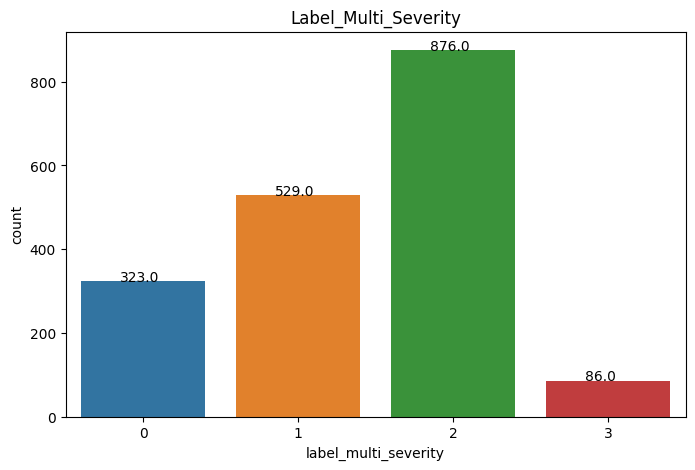

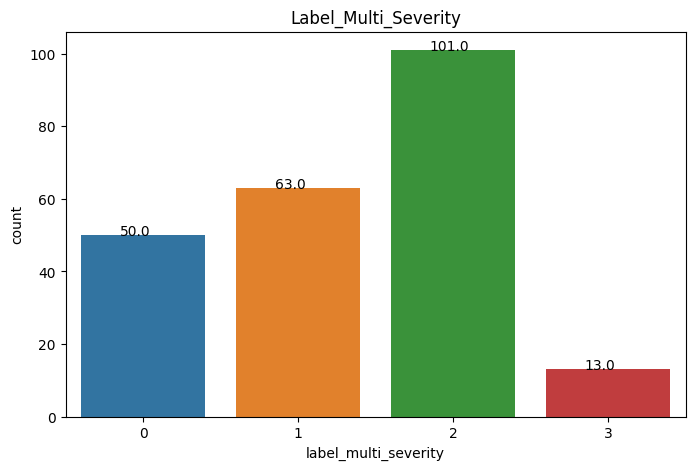

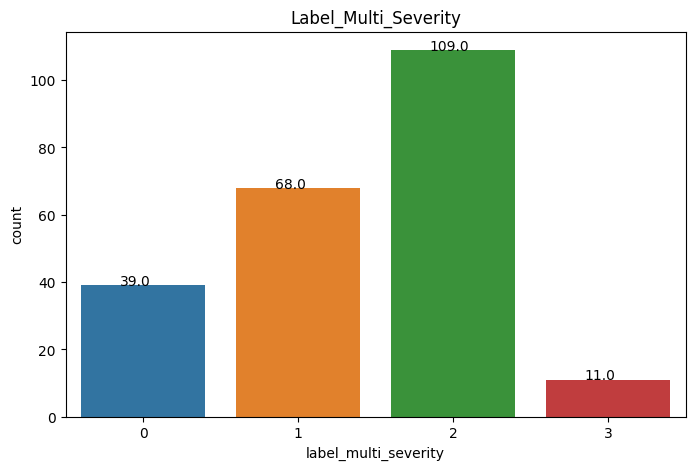

In [36]:
def plot_class(df):
    fig , ax = plt.subplots(figsize=(8,5))
    ax =sns.countplot(x=labelCol, data=df,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title(labelCol.title())
    plt.show()
    
plot_class(train)
plot_class(val)
plot_class(test)

# Process Data  Layer

In [37]:
# dataframe to  tf.data
def multiple_label_df_to_dataset(dataframe, shuffle=True, batch_size=32):
  features = dataframe.copy()
  labels = features.pop(labelCol)
  labels  = tf.keras.utils.to_categorical(labels, num_classes=nLabel)
    
  ds = tf.data.Dataset.from_tensor_slices(( dict(features), labels ))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(features))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds
     
     

In [38]:
# Tensorflow format
print("Explore Data from Tensor before keras data processing")
batch_size = 3  # list 3 sample data
train_ds =multiple_label_df_to_dataset(train, batch_size=batch_size)

[(train_features, label_batch)] = train_ds.take(1)
print("========Features==========")
print('Every feature:', list(train_features.keys()))
print('product_type:', train_features['product_type'])  # sample cate feature
print('open_to_close_hour:', train_features['open_to_close_hour'])  # sample numberic feature
print("========Labels==========")
print(f'{label_batch }')

Explore Data from Tensor before keras data processing
========Features==========
Every feature: ['sla', 'product_type', 'brand', 'service_type', 'incident_type', 'open_to_close_hour', 'response_to_resolved_hour']
product_type: tf.Tensor([b'Switch' b'Software' b'Storage'], shape=(3,), dtype=string)
open_to_close_hour: tf.Tensor([ 13.16666667 121.41666667   6.1       ], shape=(3,), dtype=float64)
========Labels==========
[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


##Process data to do  normalization and one-hot by Scikit-Learn
[http://localhost:8888/lab/tree/MyQuantFinProject/MyYoutube-Demo/google_data_ai/t3-transform-data.ipynb](t3-transform-data.ipynb)

In [39]:
# Normalizaton and categorical Endcoding

def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization(axis=None)

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [40]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))
     

In [41]:
batch_size =32
train_ds = multiple_label_df_to_dataset (train, batch_size=batch_size)
val_ds = multiple_label_df_to_dataset(val, batch_size=batch_size)
test_ds = multiple_label_df_to_dataset(test, batch_size=batch_size)




In [42]:
all_inputs = []
encoded_features = []
numInputFeatToInitNodeUnit=0

# Numeric features.
for header in numbericCols:
  stat_data=train[header].describe()
  print(f"{header}: Mean={stat_data['mean']} and Std={stat_data['std']}")  
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)
    
numInputFeatToInitNodeUnit=numInputFeatToInitNodeUnit+len(numbericCols)
    
    # Categorical features encoded as string.
categorical_cols = cateCols
for header in categorical_cols:
  listCateItem=train[header].unique()
  noCateItem=len(listCateItem)
  numInputFeatToInitNodeUnit=numInputFeatToInitNodeUnit+noCateItem +1  # last 1 is unknow
    
  print(f"{header} = {noCateItem} : {listCateItem}")

  print(header)  
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string')
                                        
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)


print(f"Total column to initialize first node input: {numInputFeatToInitNodeUnit}")

open_to_close_hour: Mean=96.70577912532157 and Std=264.30857031412927
response_to_resolved_hour: Mean=69.23291988239617 and Std=210.15946331055562
sla = 7 : ['24x7 4Hrs Resolution Time' '8x5 4Hrs Response Time'
 '24x7 6Hrs Resolution Time' '24x7 4Hrs Response Time'
 '9x5xNBD 4Hrs Response Time' '24x7 6Hrs Response Time' 'Non MA']
sla
product_type = 10 : ['Server' 'Software' 'Other' 'Firewall' 'Hardware' 'Storage' 'Switch'
 'Access Point' 'Security' 'Tape Library']
product_type
brand = 23 : ['IBM' 'Microsoft' 'F5' 'Nutanix' 'CheckPoint' 'Broadcom' 'CIMCO-CMMS'
 'eUnite' 'Fortinet' 'EMC' 'HPE' 'YIP' 'DELL' 'Cisco' 'SAPB1' 'Veeam'
 'NetApp' 'Oracle' 'VMWare' 'Red Hat' 'Veritas' 'Palo Alto' 'Trend Micro']
brand
service_type = 2 : ['Incident' 'Request']
service_type
incident_type = 21 : ['Hard Disk Drive Failure' 'General Incident' 'Software'
 'Network Cable Failure' 'Maintenance System' 'Upgrade Software'
 'Network Adapter Failure' 'Report' 'Memory Failure'
 'System Board Failure' 'Control

# Build and Train and Eveluate and Plot Result

In [43]:
def plot_metrics(history,metric):
    plt.figure(figsize=(15,8))
    plt.title(metric)
    plt.plot(history.history[metric], label='train')
    plt.plot(history.history[f'val_{metric}'], label='validation')
    plt.legend()
    plt.show() 


In [44]:
# def build_model(num_units_1,num_units_layer2, dropout_rate):
def build_model(num_units_layer1, dropout_rate):
    
    all_features = tf.keras.layers.concatenate(encoded_features)
   
    x = tf.keras.layers.Dense(num_units_layer1, activation="relu")(all_features)
    
    if dropout_rate>0:
     x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # x = tf.keras.layers.Dense(num_units_layer1, activation="relu")(x)
    # if dropout_rate>0:
    #  x = tf.keras.layers.Dropout(dropout_rate)(x)

    output = tf.keras.layers.Dense(nLabel,activation=tf.nn.softmax)(x)

    model = tf.keras.Model(all_inputs, output)
    

    model.compile(optimizer='adam',
                      loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

    return model


# METRICS = [
#       keras.metrics.BinaryAccuracy(name='accuracy'),
#       keras.metrics.Precision(name='precision'),
#       keras.metrics.Recall(name='recall'),
#       keras.metrics.AUC(name='auc'),
# ]


In [45]:
def train_model(model,x_epochs,x_batch_size):  
    # model.summary()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=nEarlyPatience, verbose=1)  
    
    history =model.fit(train_ds, validation_data=val_ds,epochs=x_epochs,batch_size=x_batch_size,callbacks=[early_stopping])
    return history
  


# Test Run Model

In [46]:
print("1#Build model")

#model=build_model(32,0)
model=build_model(numInputFeatToInitNodeUnit,0.1)

print(model.summary())


1#Build model
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sla (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 product_type (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 brand (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 service_type (InputLayer)      [(None, 1)]          0           []                               
                                                                              

In [47]:
print("2#Train model")
history=train_model(model,100,32)
print("=============================================================================")


2#Train model
Epoch 1/100
57/57 [==============================] - 4s 19ms/step - loss: 1.1526 - accuracy: 0.5138 - val_loss: 1.0694 - val_accuracy: 0.5022
Epoch 2/100
57/57 [==============================] - 0s 6ms/step - loss: 0.9481 - accuracy: 0.6031 - val_loss: 0.9425 - val_accuracy: 0.6035
Epoch 3/100
57/57 [==============================] - 0s 6ms/step - loss: 0.8455 - accuracy: 0.6648 - val_loss: 0.8555 - val_accuracy: 0.6608
Epoch 4/100
57/57 [==============================] - 0s 5ms/step - loss: 0.7833 - accuracy: 0.6814 - val_loss: 0.8021 - val_accuracy: 0.6916
Epoch 5/100
57/57 [==============================] - 0s 5ms/step - loss: 0.7474 - accuracy: 0.6924 - val_loss: 0.7853 - val_accuracy: 0.7137
Epoch 6/100
57/57 [==============================] - 0s 5ms/step - loss: 0.7263 - accuracy: 0.7051 - val_loss: 0.7652 - val_accuracy: 0.7004
Epoch 7/100
57/57 [==============================] - 0s 5ms/step - loss: 0.7054 - accuracy: 0.7067 - val_loss: 0.7543 - val_accuracy: 0.709

In [50]:
print("3#Evaluate model")

loss_val, accuracy_val = model.evaluate(val_ds)
print(f"Average Loss - Accuracy on Eveluation {loss_val} -{accuracy_val}")

loss_test, accuracy_test = model.evaluate(test_ds)
print(f"Average Loss - Accuracy on Test {loss_test} -{accuracy_test}")

print("=============================================================================")


# production data set to 12MAr23
# 7/7 [==============================] - 0s 2ms/step - loss: 0.6655 - accuracy: 0.7689
# Average Loss - Accuracy on Eveluation 0.6654592752456665 -0.7688679099082947
# 7/7 [==============================] - 0s 2ms/step - loss: 0.6977 - accuracy: 0.7358
# Average Loss - Accuracy on Test 0.6977102160453796 -0.7358490824699402


# demo set to 04 April23
# 8/8 [==============================] - 0s 2ms/step - loss: 0.7334 - accuracy: 0.7621
# Average Loss - Accuracy on Eveluation 0.7333917617797852 -0.7621145248413086
# 8/8 [==============================] - 0s 3ms/step - loss: 0.7452 - accuracy: 0.6740
# Average Loss - Accuracy on Test 0.745168149471283 -0.6740087866783142
# ============================================================================

3#Evaluate model
8/8 [==============================] - 0s 5ms/step - loss: 0.7105 - accuracy: 0.7709
Average Loss - Accuracy on Eveluation 0.7104623317718506 -0.7709251046180725
8/8 [==============================] - 0s 6ms/step - loss: 0.7455 - accuracy: 0.6696
Average Loss - Accuracy on Test 0.7455223202705383 -0.6696035265922546


4#Explore Result model


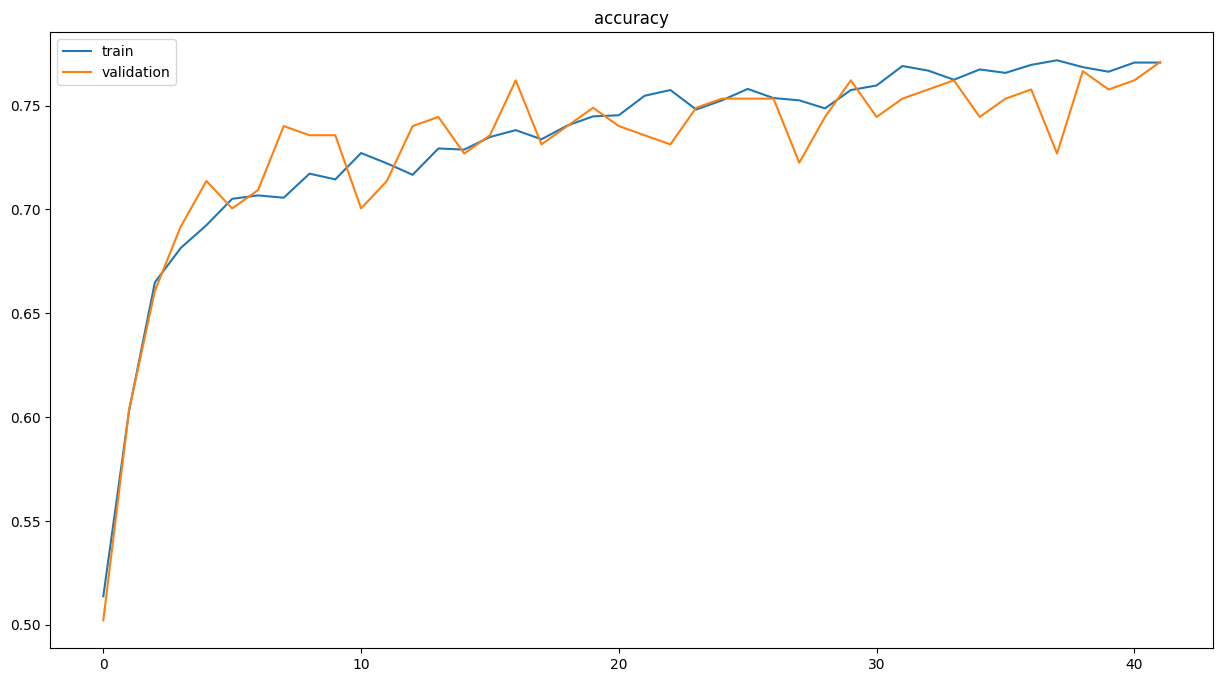

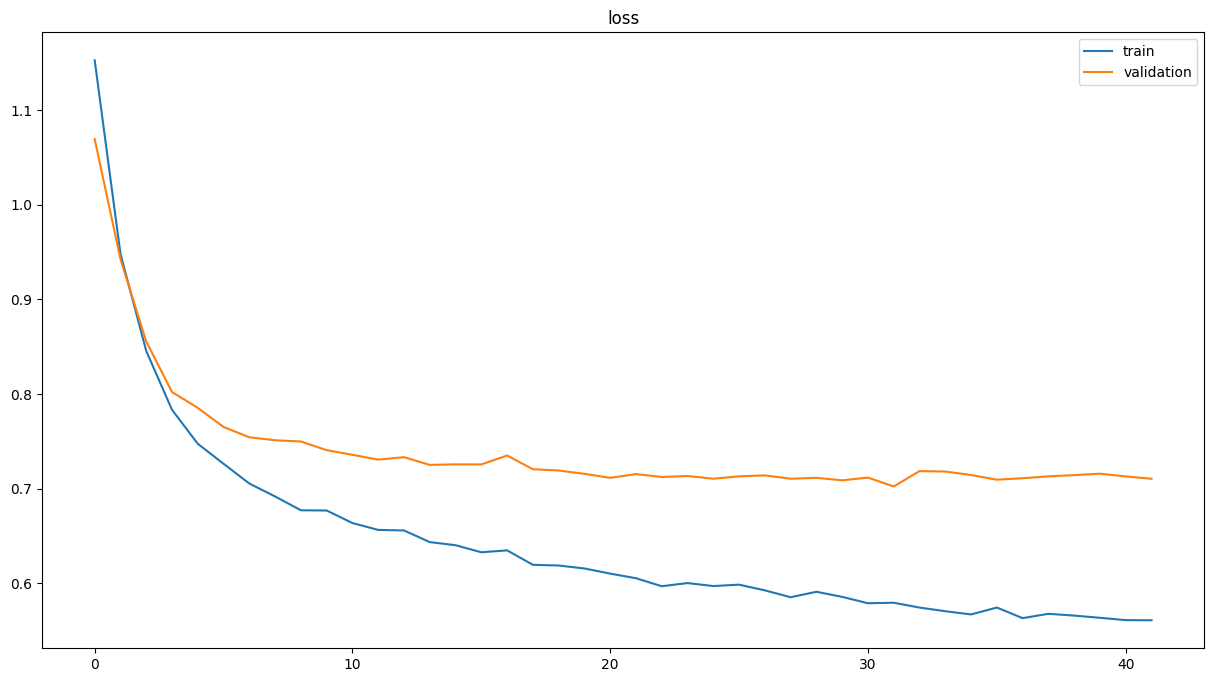

In [51]:
print("4#Explore Result model")
plot_metrics(history,'accuracy')
plot_metrics(history,"loss")


# Save Model

In [48]:
model.save(model_dir)
# 1 foloder contain many files and folder

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


# Test Predict

In [56]:
#label_multi_severity

m = tf.keras.models.load_model(model_dir)

sample={"sla":"24x7 4Hrs Response Time",
        "product_type":"Server",
        "brand":"VMWare",                
        "service_type":"Incident",
        "incident_type":"General Incident",
        "open_to_close_hour":10,
        "response_to_resolved_hour":6.000000 \
       }
      
print("===============================================================================================================")    
print("convert pain data to serdor as input to predict")    
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
print(input_dict)

predictionList = m.predict(input_dict)
print(predictionList)

#JSOML
# {
#  "instances": [
#      {
#       "brand":["NetApp"],
#       "incident_type":["General Incident"],
#       "open_to_close_hour":[7.0],
#       "product_type":["Storage"],
#       "response_to_resolved_hour":[5.5],
#       "service_type":["Incident"],
#       "sla":["24x7 6Hrs Response Time"]
#      },
#   {
#       "brand":["HPE"],
#       "incident_type":["General Incident"],
#       "open_to_close_hour":[3.0],
#       "product_type":["Server"],
#       "response_to_resolved_hour":[1.5],
#       "service_type":["Incident"],
#       "sla":["24x7 6Hrs Response Time"]
#      }
#  ]
#  }

convert pain data to serdor as input to predict
{'sla': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'24x7 4Hrs Response Time'], dtype=object)>, 'product_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Server'], dtype=object)>, 'brand': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'VMWare'], dtype=object)>, 'service_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Incident'], dtype=object)>, 'incident_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'General Incident'], dtype=object)>, 'open_to_close_hour': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([10])>, 'response_to_resolved_hour': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([6.], dtype=float32)>}
1/1 [==============================] - 1s 1s/step
[[0.01388785 0.15315497 0.82575476 0.00720237]]


In [57]:
prob = tf.nn.softmax(predictionList[0])
print(f"{(100 * prob)} % at {np.argmax(prob, axis=0)} as Severity") 
print()

[18.536108 21.305977 41.745323 18.412598] % at 2 as Severity



# Copy Model From Local To GCS For Cloud Function To Invoke Model

In [52]:
MODEL_BUCKET = f'gs://demo-tf-incident-{projectId}'
REGION='asia-southeast1'

In [53]:
!gsutil mb -l $REGION $MODEL_BUCKET

Creating gs://demo-tf-incident-pongthorn/...


In [54]:
!gsutil -m cp -r ./$model_dir/* $MODEL_BUCKET/$model_dir



Copying file://.\model\keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file://.\model\variables\variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
/ [0/5 files][    0.0 B/513.4 KiB]   0% Done                                    
Copying file://.\model\saved_model.pb [Content-Type=application/octet-stream]...
/ [0/5 files][    0.0 B/513.4 KiB]   0% Done                                    
/ [0/5 files][    0.0 B/513.4 KiB]   0% Done                                    
Copying file://.\model\variables\variables.index [Content-Type=application/octet-stream]...
/ [0/5 files][    0.0 B/513.4 KiB]   0% Done                                    
Copying file://.\model\fingerprint.pb [Content-Type=application/octet-stream]...
/ [0/5 files][    0.0 B/513.4 KiB]   0% Done                                    
/ [1/5 files][113.8 KiB/513.4 KiB]  22% Done                                    
/ [2/5 files][113.8 KiB/513.4 KiB]  22% Done                          